# Baseline Creation

In [1]:
import re
from nltk.text import Text
import numpy as np
import pipeline_caller

caller = pipeline_caller.PipelineCaller()

In [2]:
with open('halil_inal.txt', 'r', encoding = 'utf-8') as f1:
    halil_raw = f1.read()

In [3]:
with open('ilber_ort.txt', 'r', encoding = 'utf-8') as f2:
    ilber_raw = f2.read()

In [4]:
def initial_cleaner(text):
    cleaned_text = list(map(lambda x: x \
                     .replace("\n", " ") \
                     .replace("\uf0f5", "ı") \
                     .replace("\x0c", ""), text.split()))
    
    return cleaned_text

In [5]:
halil_cleaned = " ".join(initial_cleaner(halil_raw))
ilber_cleaned = " ".join(initial_cleaner(ilber_raw))

In [6]:
#Applying ITU NLP Sentence Splitter

ilber_tkz = caller.call('sentencesplitter', ilber_cleaned, 'luUiBPs1DC9iAxrWlFLRDDN8atWtGGL7').splitlines()
halil_tkz = caller.call('sentencesplitter', halil_cleaned, 'luUiBPs1DC9iAxrWlFLRDDN8atWtGGL7').splitlines()

In [7]:
minority_keywords = ["yunan", "ermeni", "kürt", "alevi", " arap", "boşnak", "çerkes", "çingene", "yahudi", "rum", "gayri", \
                    "hristiyan", "arnavut"]


ilber_minority_sentences = []

for sent in ilber_tkz:
    for kw in minority_keywords:
        for word in sent.split():
            if word.lower().startswith(kw):
                ilber_minority_sentences.append(sent)
            else:
                continue
            

halil_minority_sentences = []

for sent in halil_tkz:
    for kw in minority_keywords:
        for word in sent.split():
            if word.lower().startswith(kw):
                halil_minority_sentences.append(sent)
            else:
                continue


In [8]:
print("İlbert Ortaylı Minority Sentences:", len(ilber_minority_sentences), "\n",\
      "Halil İnalcık Minority Sentences:", len(halil_minority_sentences))

İlbert Ortaylı Minority Sentences: 337 
 Halil İnalcık Minority Sentences: 279


In [11]:
with open("ilber_minority_sentences.txt", "w") as ilber:
    ilber.write("\n".join(str(sentence) for sentence in ilber_minority_sentences))

In [12]:
with open("halil_minority_sentences.txt", "w") as halil:
    halil.write("\n".join(str(sentence) for sentence in halil_minority_sentences))

# Sentiment Analysis

In [15]:
import re
from nltk.text import Text
import numpy as np
from trtokenizer.tr_tokenizer import SentenceTokenizer, WordTokenizer

In [16]:
sent_tok = SentenceTokenizer()
word_tok = WordTokenizer()

In [17]:
import zeyrek
analyzer = zeyrek.MorphAnalyzer()

def lemmatize_text(text):
    
    lemmatized_words = []
    
    for sent in text:
        for item in analyzer.lemmatize(sent):
            if item[0].istitle():
                lemmatized_words.append(item[1][0].title())
            else:
                lemmatized_words.append(item[1][0])
    
    sentences_stemmed = list(sent_tok.tokenize(" ".join(lemmatized_words)))
    return sentences_stemmed

In [18]:
ilber_minority_lemmatized = lemmatize_text(ilber_minority_sentences)
halil_minority_lemmatized = lemmatize_text(halil_minority_sentences)

In [19]:
print(ilber_minority_lemmatized[:3])
print("-------------------------------------------------------------------")

['Historia Latin tarih kelime , Aslı Yuna ; “ somut bir malzeme , müşahhas bir malzeme , bilgi ” demek .', 'Yumak aslında tarih çok sevmek ada değil ; Arab gibi , İran gibi değil .', 'Herodot tarih olmak başka millet soyutlamak , tecerrüd etmek bir Yumak medeniyet tarz yok .']
-------------------------------------------------------------------


In [20]:
import pandas as pd

sent_lexicon = pd.read_excel('STN.xlsx')

In [21]:
print(sent_lexicon.shape)
print(sent_lexicon['synonyms'].isnull().values.any())
sent_lexicon = sent_lexicon[sent_lexicon['synonyms'].notna()]
print(sent_lexicon.shape)

(14795, 11)
True
(13526, 11)


In [22]:
def sentiment_classifier_count(text):
    sentence_values = pd.DataFrame()
    text = text.split()
    for word in text:
        word = word.lower()
        try:
            if  sent_lexicon['synonyms'].str.contains(word).any():
                synset_vals = sent_lexicon[sent_lexicon['synonyms'].str.contains(word)][['neg value', 'obj value', 'pos value']]
                word_negative_prob = sum(synset_vals["neg value"]) / synset_vals.shape[0]
                word_obj_prob = sum(synset_vals["obj value"]) / synset_vals.shape[0]
                word_pos_prob = sum(synset_vals["pos value"]) / synset_vals.shape[0]
                merged = {"neg": word_negative_prob, "obj": word_obj_prob, "pos": word_pos_prob}
                sentence_values = sentence_values.append(merged, ignore_index=True)
            else:
                continue
        except:
            continue
    
    neg_words_num = 0
    obj_words_num = 0
    pos_words_num = 0

    try:
        for ix, row in sentence_values.iterrows():
            neg = (row[0])
            obj = (row[1])
            pos = (row[2])
            row_values = [neg, obj, pos]
            if row_values.index(max(row_values)) == 0:
                neg_words_num = neg_words_num + 1
            
            if row_values.index(max(row_values)) == 1:
                obj_words_num = obj_words_num +1
            
            if row_values.index(max(row_values)) == 2:
                pos_words_num = pos_words_num + 1
            
        verdict_counts = (neg_words_num, obj_words_num, pos_words_num)
            
        if verdict_counts.index(max(verdict_counts)) == 0:
            verdict = 'negative'
        
        elif verdict_counts.index(max(verdict_counts)) == 1:
            if verdict_counts[0] > verdict_counts[2]:
                verdict = 'negative'
                
            elif verdict_counts[0] < verdict_counts[2]:
                verdict = 'positive'
            else:
                verdict = 'objective'
            
        elif verdict_counts.index(max(verdict_counts)) == 2:
            verdict = 'positive'
        
        else:
            verdict = 'unidentified'
        
    except:
        verdict = 'unidentified'
    return verdict

In [25]:
ilber_classified = []

for sent in ilber_minority_lemmatized:
    if len(sent.split()) > 6:
        verdict = sentiment_classifier_count(sent)
        row = (str(sent), verdict)
        ilber_classified.append(row)    
    else:
        continue

In [26]:
df_ilber_classified = pd.DataFrame(ilber_classified, columns = ["Sentence", "Class"])
print(df_ilber_classified.head())
print("----------------------------")
print(df_ilber_classified["Class"].value_counts())

                                            Sentence      Class
0  Historia Latin tarih kelime , Aslı Yuna ; “ so...  objective
1  Yumak aslında tarih çok sevmek ada değil ; Ara...   negative
2  Herodot tarih olmak başka millet soyutlamak , ...  objective
3  Dolayısıyla , barbar demek Kavram Yumak tarafı...   negative
4  Yumak için barbar , hiç tesbit etmek , tanımak...   negative
----------------------------
objective    175
positive      95
negative      85
Name: Class, dtype: int64


In [27]:
df_ilber_classified.to_csv('lexicon_countbased_ilber.csv', index=False)

In [28]:
halil_classified = []

for sent in halil_minority_lemmatized:
    if len(sent.split()) > 6:
        verdict = sentiment_classifier_count(sent)
        row = (str(sent), verdict)
        halil_classified.append(row)    
    else:
        continue

In [29]:
df_halil_classified = pd.DataFrame(halil_classified, columns = ["Sentence", "Class"])
print(df_halil_classified.head())
print("----------------------------")
print(df_halil_classified["Class"].value_counts())

                                            Sentence      Class
0  Rum ahali kıyı kaçmak veya şehir yen gelen Uz ...   negative
1  Orta Toros bölge , Kilikya–Çukurovadaki Küçük ...  objective
2  Rumeli faal Bap Saltuk , Batı göçmek Babai , o...  objective
3  Bayezid 1484 Akkerman sefer on türbe ve zaviye...  objective
4  Keykavus desteklemek Türkmen 40 Kadar Türkmen ...  objective
----------------------------
objective    145
negative      84
positive      81
Name: Class, dtype: int64


In [30]:
df_halil_classified.to_csv('lexicon_countbased_halil.csv', index=False)

# Plotting

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")

In [38]:
df_halil_classified.loc[df_halil_classified.Class == 1, 'Class'] = "negative"
df_halil_classified.loc[df_halil_classified.Class == 2, 'Class'] = "objective"
df_halil_classified.loc[df_halil_classified.Class == 3, 'Class'] = "positive"

In [58]:
df_halil_classified["Author"] = "İnalcık (2009)"

In [59]:
df_ilber_classified["Author"] = "Ortaylı (2010)"

In [60]:
frames= [df_ilber_classified, df_halil_classified]

merged_results = pd.concat(frames)

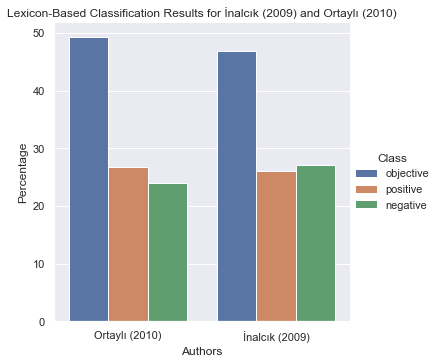

In [62]:
x, y = 'Author', 'Class'

plot_collective = (merged_results
.groupby(x)[y]
.value_counts(normalize=True)
.mul(100)
.rename('percent')
.reset_index()
.pipe((sns.catplot,'data'), x=x,y='percent',hue=y, kind='bar'))

plot_collective.set(xlabel="Authors", ylabel = "Percentage", title='Lexicon-Based Classification Results for İnalcık (2009) and Ortaylı (2010)')
plt.savefig('halil_ilber.png', dpi=900, bbox_inches='tight')